# Key Process Indicators (KPIs)

This code will calculate the number of commits and plot a line graph of commits v. date.

In [1]:
# Import the required libraries and modules.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# These next lines are for using LaTeX
# If you use this, all text will be LaTeX style
#import matplotlib
#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True

In [2]:
# Read the csv data file. It is encoded in UTF-8.
# There are several columns of daily commits.
# Read the csv file into the data frame "commits", and set "date" as the index
commits = pd.read_csv('kpis.csv', parse_dates=True, index_col='Date')

In [3]:
#commits['Total'] = commits.sum(axis=1)
#commits
commits['Total']= commits.ForteFoto + commits.Private + commits.Support + \
                    commits.Jupyter + commits.Tableau + commits.KPI
# Calculate the median for Total
# One day fix this so that it's not an additional column, but a number to plot
commits['Median'] = commits['Total'].median()

In [4]:
# Define the graph title and subtitle, and the x and y axis labels.
title = 'Key Performance Indicator'
subtitle = 'Git Commits'
ylabel = 'Commits'
xlabel = 'Date'

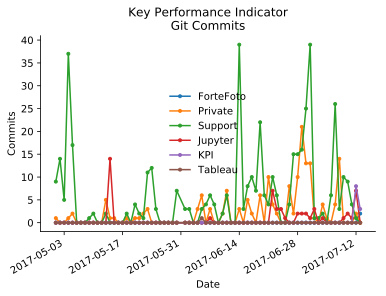

In [5]:
# Create a graph of "individual commits v. date"

# Create a single subplot
ax1 = plt.subplot(111)
# Plot "total commits v. date"
commits[['ForteFoto', 'Private', 'Support', 'Jupyter', 'KPI', 'Tableau']] \
    .plot.line(legend=True, ax=ax1, marker='o', markersize=3).axis('auto')
# Remove the top and right spines
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
# Place the ticks outside the axes
ax1.tick_params(direction='out')
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.set_title(title + '\n' + subtitle)
# Add the Y axis label
ax1.set_ylabel(ylabel)
# Add the X axis label
ax1.set_xlabel(xlabel)
# Remove box around legend
ax1.legend(frameon=False)
# Save the graph as svg and pdf.
ax1.figure.savefig('kpi_commits.svg', format='svg')
ax1.figure.savefig('kpi_commits.pdf', format='pdf')

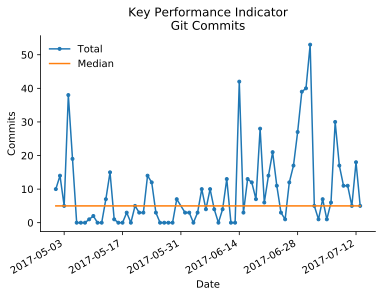

In [6]:
# Create a graph of "total commits v. date"

# Create a single subplot
ax2 = plt.subplot(111)
# Plot "total commits v. date"
commits['Total'].plot.line(legend=True, ax=ax2, marker='o', markersize=3).axis('auto')
commits['Median'].plot.line(legend=True, ax=ax2).axis('auto')
# Remove the top and right spines
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
# Place the ticks outside the axes
ax2.tick_params(direction='out')
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
# Add the graph title and subtitle
#ax2.set_title(r'\textbf{' + title + '}' + '\n' + subtitle)
ax2.set_title(title + '\n' + subtitle)
# Add the Y axis label
ax2.set_ylabel(ylabel)
# Add the X axis label
ax2.set_xlabel(xlabel)
# Set axis properties
ax2.axis('auto')
# Remove box around legend
ax2.legend(frameon=False)
# Save the graph as svg and pdf
ax2.figure.savefig('kpi_commits_total.svg', format='svg')
ax2.figure.savefig('kpi_commits_total.pdf', format='pdf')